In [1]:
#experiment name and snapshot folder (used for model persistence)
experiment_setup_name = "tutorial.gym.atari.spaceinvaders-v0.cnn"
snapshot_path = "."


#gym game title
GAME_TITLE = 'SpaceInvaders-v0'

#how many parallel game instances can your machine tolerate
N_PARALLEL_GAMES = 10


#how long is one replay session from a batch

#since we have window-like memory (no recurrent layers), we can use relatively small session weights
replay_seq_len = 10


In [2]:
#this is my machine-specific config. replace if are not me.

#theano device selection
%env THEANO_FLAGS='device=gpu2'


#snapshot path - where neural network snapshots are saved during the main training loop
!mkdir ./agentnet_snapshots/
snapshot_path = "./agentnet_snapshots/"


env: THEANO_FLAGS='device=gpu2'
mkdir: cannot create directory `./agentnet_snapshots/': File exists


# This tutorial is a showcase on how to use AgentNet for OpenAI Gym environments

* We take Space Invadets game as an example
* We train a simple-stupid convolutional network for Q_learning objective
* We do have a GPU for that, so if you don't, we have a "linear regression" mode - just uncomment it :)
* We train via experience replay using SessionPoolEnvironment, explained below
* We do NOT use recurrent layers for simplicity
* We do NOT use "smart" experience replay for simplicity
* We use simple stupid one-step q-learning.. you guessed it, for simplicity


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym
  
  
### Installing it
 * If nothing changed on their side, to run this, you bacically need to follow their install instructions - 
 
```
git clone https://github.com/openai/gym.git
cd gym
pip install -e .[all]
```

In [3]:
#Choose your side

#Sith
#mode = "simple convnet"

#Jedi
mode = "dense nn"

#Stormtrooper
#mode = "linear regression"


In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports

import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


Using gpu device 2: Tesla K40m (CNMeM is disabled, CuDNN 4004)


In [5]:
%load_ext autoreload
%autoreload 2

# Experiment setup
* Here we basically just load the game

[2016-04-30 17:19:12,491] Making new env: SpaceInvaders-v0


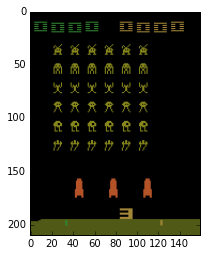

In [6]:
import gym
atari = gym.make(GAME_TITLE)
atari.reset()
plt.imshow(atari.render('rgb_array'))

In [7]:
n_actions = atari.action_space.n
observation_shape = (None,)+atari.observation_space.shape
action_names = atari.get_action_meanings()
print action_names

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [8]:
del atari

# agent setup
* An agent implementation may contain these parts:
 * Observation(s)
   * InputLayers where observed game states (here - images) are sent at each tick 
 * Memory layer(s)
   * A dictionary that maps "New memory layers" to "prev memory layers"
 * Policy layer (e.g. Q-values or probabilities)
   * in this case, a lasagne dense layer based on observation layer
 * Resolver - acton picker layer
   * in this case, the resolver has epsilon-greedy policy
  
  
### Simple no-memory model

Since we have almost fully observable environment AND we want to keep baseline simple, we shall use NO agent memories and a simple lasagne CNN to process observations.



In [9]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import WindowAugmentation
from agentnet.agent import Agent

In [10]:
import lasagne

#image observation
observation_layer = lasagne.layers.InputLayer(observation_shape,
                                                    name="images input")

observation_reshape = lasagne.layers.dimshuffle(observation_layer,(0,3,1,2))



#convolution
if mode == 'simple convnet':
    print "Using some CNNs"
    cnn = lasagne.layers.Conv2DLayer(observation_reshape,
                                     num_filters=64,filter_size=(5,5),name='cnn0')
    cnn = lasagne.layers.MaxPool2DLayer(cnn,(5,5), name='pool0')
    cnn = lasagne.layers.Conv2DLayer(cnn,num_filters=128,filter_size=(5,5),name='cnn2')
    cnn = lasagne.layers.MaxPool2DLayer(cnn,(5,5), name='pool1')
    dnn = lasagne.layers.DropoutLayer(cnn,name = "dropout", p=0.05) #will get deterministic during evaluation
    dnn = lasagne.layers.DenseLayer(dnn,num_units=500,name='dense1')
    nn = dnn
#dense with dropout
elif mode == "dense nn":
    print "Using simple dense network"
    
    dnn = lasagne.layers.DenseLayer(observation_reshape,num_units=500,name='dense0')
    dnn = lasagne.layers.DropoutLayer(dnn,name = "dropout", p=0.05) #will get deterministic during evaluation
    dnn = lasagne.layers.DenseLayer(dnn,num_units=300,name='dense1')
    nn = dnn

#linear regression
else:
    print "Using linear model"
    nn = observation_reshape



    
flat_nn = lasagne.layers.FlattenLayer(nn,outdim=2,name='flat frame output')


#memory
#using simple window-based memory that stores several states
#the SpaceInvaders environment does not need any more as it is almost fully-observed

window_size = 3
prev_window = lasagne.layers.InputLayer((None,window_size,flat_nn.output_shape[1]),
                                        name = "previous window state")

window = WindowAugmentation(flat_nn,prev_window,name = "new window state")



memory_dict = {window:prev_window}


#q_eval
q_eval = lasagne.layers.DenseLayer(window,
                                   num_units = n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,
                                   name="QEvaluator")
#resolver
epsilon = theano.shared(np.float32(0.5),"e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")



#all together
agent = Agent(observation_layer,
              memory_dict,
              q_eval,resolver)


Using simple dense network


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[dense0.W, dense0.b, dense1.W, dense1.b, QEvaluator.W, QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * to be covered where they are more useful
 

* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Agent step function
* compute action and next state given observation and prev state

In [12]:
applier_observation = T.tensor4("input image",dtype=floatX)

applier_window = T.tensor3("prev window",dtype=floatX)


res =agent.get_agent_reaction({window:applier_window},
                              applier_observation,
                              deterministic = True #disable dropout here. Only enable in experience replay
                             )


applier_actions,applier_new_states,applier_policy = res

applier_fun = theano.function([applier_observation,applier_window],
        applier_actions+applier_new_states)


In [13]:
#a nice pythonic interface
def step(observation, prev_memories = 'zeros',batch_size = N_PARALLEL_GAMES):
    """ returns actions and new states given observation and prev state
    Prev state in default setup should be [prev window,]"""
    #default to zeros
    if prev_memories == 'zeros':
        prev_memories = [np.zeros((batch_size,)+tuple(mem.output_shape[1:]),
                                  dtype=floatX) 
                         for mem in agent.state_variables]
    
    res = applier_fun(np.array(observation),*prev_memories)
    action = res[0]
    memories = res[1:]
    return action,memories

# Create and manage a pool of atari sessions to play with

In [14]:
#A whole lot of space invaders

class GamePool:
    def __init__(self,game_title,n_games):
        """
        A pool that stores several
           - game states (gym environment)
           - prev_observations - last agent observations
           - prev memory states - last agent hidden states
           
       """
        
        
        self.ataries = [gym.make(game_title) for i in range(n_games)]

        self.prev_observations = [atari.reset() for atari in self.ataries]
    
        self.prev_memory_states = 'zeros'

pool = GamePool(GAME_TITLE, N_PARALLEL_GAMES)


[2016-04-30 17:19:14,621] Making new env: SpaceInvaders-v0
[2016-04-30 17:19:14,652] Making new env: SpaceInvaders-v0
[2016-04-30 17:19:14,683] Making new env: SpaceInvaders-v0
[2016-04-30 17:19:14,714] Making new env: SpaceInvaders-v0
[2016-04-30 17:19:14,744] Making new env: SpaceInvaders-v0
[2016-04-30 17:19:14,774] Making new env: SpaceInvaders-v0
[2016-04-30 17:19:14,804] Making new env: SpaceInvaders-v0
[2016-04-30 17:19:14,835] Making new env: SpaceInvaders-v0
[2016-04-30 17:19:14,865] Making new env: SpaceInvaders-v0
[2016-04-30 17:19:14,896] Making new env: SpaceInvaders-v0


In [15]:
def interact(pool,n_steps = 100,verbose=False):
    """generate interaction sessions with ataries (openAI gym atari environments)
    Sessions will have length n_steps. 
    Each time one of games is finished, it is immediately getting reset"""
    history_log = []
        
    prev_observations = pool.prev_observations 
    
    prev_memory_states = pool.prev_memory_states
    
    
    
    for i in range(n_steps):
        
        actions,new_memory_states = step(prev_observations,prev_memory_states)

        
        new_observations, cur_rewards, is_done, infos = \
            zip(*map(
                     lambda atari, action: atari.step(action), 
                     pool.ataries,actions))
            
        new_observations = np.array(new_observations)
        
        for i in range(len(pool.ataries)):
            if is_done[i]:
                new_observations[i] = pool.ataries[i].reset()
                
                for m_i in range(len(new_memory_states)):
                    new_memory_states[m_i][i] = 0
                    
                if verbose:
                    print "atari",i,"reloaded"
        
        
        #append observation -> action -> reward tuple
        history_log.append((prev_observations,actions,cur_rewards,new_memory_states,is_done,infos))
        
        prev_observations = new_observations
        prev_memory_states = new_memory_states
                
    pool.prev_memory_states = prev_memory_states
    pool.prev_observations = prev_observations
    
    return zip(*history_log)
    

In [16]:
%%time
obsevation_log,action_log,reward_log,_,_,_  = interact(pool,50)


print np.array(reward_log)[:10].T
print np.array(action_names)[np.array(action_log)[:3,:5]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[['LEFT' 'RIGHTFIRE' 'LEFT' 'LEFT' 'RIGHTFIRE']
 ['LEFT' 'RIGHTFIRE' 'NOOP' 'RIGHTFIRE' 'RIGHT']
 ['LEFTFIRE' 'LEFT' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE']]
CPU times: user 900 ms, sys: 116 ms, total: 1.02 s
Wall time: 1.05 s


# experience replay pool
### we shall use session pool environment to immediately train on new sessions
* theoretically, this environemnt is designed for storing a lot of game sessions and training on random batches,
* but for the sake of baseline, it's a one-time usage pool

1. Interact with ALE, get play sessions
2. Store them into session environment
3. Train on them
4. Repeat

In [17]:
#Create an environment with all default parameters
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations = observation_layer,
                             actions=resolver,
                             agent_memories=[])

In [18]:
def update_pool(env, pool,n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    
    obsevation_log,action_log,reward_log,_,is_done_log,_= interact(pool,n_steps=n_steps)
    
    
    #tensor dimensions
    
    # [batch_i, time_i, width, height, rgb]
    observation_tensor = np.array(obsevation_log).swapaxes(0,1)
    
    # [batch_i,time_i]
    action_tensor = np.array(action_log).swapaxes(0,1)
    
    # [batch_i, time_i]
    reward_tensor = np.array(reward_log).swapaxes(0,1)

    # [batch_i, time_i]
    is_alive_tensor = 1- np.array(is_done_log,dtype = 'int8').swapaxes(0,1)
    
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,[])
    
    

In [19]:
#load first  sessions
update_pool(env,pool,replay_seq_len)

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


### Training via experience replay

* We use agent we have created to replay environment interactions inside Theano
* to than train on the replayed sessions via theano gradient propagation
* this is essentially basic Lasagne code after the following cell

In [20]:
#produce interaction sequences of length <= 10

_,observation_seq,_,_,qvalues_seq = agent.get_sessions(
    env,
    session_length=replay_seq_len,
    batch_size=env.batch_size,
)


#observation seq are the observation tensor we just loaded
#qvalues seq are agent's Qvalues obtained via experience replay


#The three "_"s are
#first - environment states - which is empty since we are using session pool as our environment
#second - a dictionary of all agent memory units (RNN, GRU, NTM) - empty as we use none of them
#last - "imagined" actions - actions agent would pick now if he was in that situation 
#                              - irrelevant since we are replaying and not actually playing the game now

#the actions agent took in the original recorded game
action_seq = env.actions[0]

#get rewards for all actions
rewards_seq = env.rewards

#get indicator whether session is still active
is_alive_seq = env.is_alive


# Evaluating loss function
* In this part we are using some basic Reinforcement Learning methods (here - Q-learning) to train
* AgentNet has plenty of such methods, but we shall use the simple Q_learning for now.
* Later you can try:
 * SARSA - simpler on-policy algorithms
 * N-step q-learning (requires n_steps parameter)
 * Advantage Actor-Critic (requires state values and probabilities instead of Q-values)


* The basic interface is .get_elementwise_objective 
  * it returns loss function (here - squared error against reference Q-values) values at each batch and tick
  
* If you want to do it the hard way instead, try .get_reference_Qvalues and compute errors on ya own
  

In [21]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.99),name = 'q_learning_gamma')


#IMPORTANT!
# If you are training on a game that has rewards far outside some [-5,+5]
# it is a good idea to downscale them to avoid divergence
scaled_reward_seq = rewards_seq
#For SpaceInvaders, however, not scaling rewards is at least working


elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                        action_seq,
                                                        rewards_seq,
                                                        is_alive_seq,
                                                        gamma_or_gammas=gamma,)

#compute mean over "alive" fragments
mse_loss = elwise_mse_loss.sum() / is_alive_seq.sum()

In [22]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-4

In [23]:
loss = mse_loss + reg_l2

#### Compute weight updates

In [24]:

updates = lasagne.updates.adadelta(loss,
                                             weights,learning_rate=0.01)

#### Some auxilary evaluation metrics

In [25]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [26]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

# session visualization tools

### [warning, this thing basicly tries to track various Qvalues over time]
### [but it's bulky and stupid, so don't try to understand it if it didn't come naturally]


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [27]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        qvalues_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False,max_n_sessions = 3,update = True):
    
    pictures = [atari.render("rgb_array") for atari in pool.ataries[:max_n_sessions]]
    
    if update:
        update_pool(env,pool,replay_seq_len)
    
    
    printables = get_printables()
    
    
    for i in range(max_n_sessions):
        plt.imshow(pictures[i])
        plt.show()
            
        qvalues_log,actions_log,reward_log, is_alive_log = map(lambda v: np.array(v[i:i+1]), printables)
        

        print_sessions(qvalues_log,actions_log,reward_log,
                       is_alive_seq = is_alive_log,
                       action_names=action_names,
                       legend = True, #do not show legend since there's too many labeled objects
                      plot_policy = with_plots)

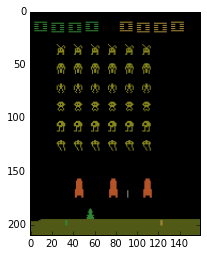

session # 0
 RIGHTFIRE(qv = 0.0) -> 0.0 |  RIGHTFIRE(qv = 25.1133289337) -> 0.0 |  RIGHTFIRE(qv = 44.5420074463) -> 0.0 |  RIGHTFIRE(qv = 60.2397346497) -> 0.0 |  RIGHTFIRE(qv = 56.192855835) -> 0.0 |  RIGHTFIRE(qv = 68.7004394531) -> 0.0 |  RIGHT(qv = 60.0944213867) -> 0.0 |  RIGHT(qv = 38.9520263672) -> 0.0 |  RIGHT(qv = 53.194278717) -> 0.0 |  RIGHT(qv = 34.6623191833) -> 5.0 |  RIGHTFIRE(qv = 53.3184928894) -> 0.0 |  RIGHTFIRE(qv = 31.672908783) -> 0.0 |  RIGHTFIRE(qv = 39.9758987427) -> 0.0 |  RIGHTFIRE(qv = 23.7286701202) -> 0.0 |  LEFTFIRE(qv = 0.569562554359) -> 0.0 |  RIGHTFIRE(qv = 47.0642929077) -> 0.0 |  RIGHTFIRE(qv = 42.4817886353) -> 0.0 |  RIGHTFIRE(qv = 48.4668159485) -> 0.0 |  RIGHTFIRE(qv = 78.9186859131) -> 0.0 |  RIGHT(qv = 64.3735122681) -> 0.0 | reached max session length


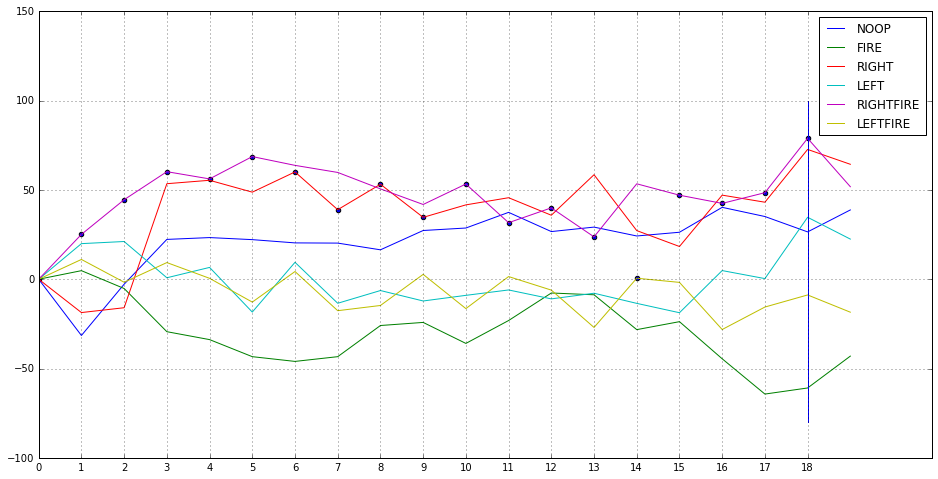

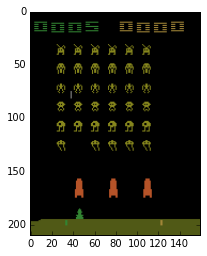

session # 0
 RIGHTFIRE(qv = 0.0) -> 0.0 |  RIGHTFIRE(qv = 23.5331802368) -> 0.0 |  RIGHTFIRE(qv = 59.3633041382) -> 0.0 |  RIGHTFIRE(qv = 75.833114624) -> 0.0 |  RIGHTFIRE(qv = 64.5729370117) -> 0.0 |  RIGHTFIRE(qv = 88.1058044434) -> 0.0 |  RIGHTFIRE(qv = 80.7324905396) -> 0.0 |  RIGHTFIRE(qv = 50.0971946716) -> 0.0 |  RIGHTFIRE(qv = 51.4873046875) -> 0.0 |  RIGHTFIRE(qv = 60.6639938354) -> 0.0 |  RIGHTFIRE(qv = 51.1385536194) -> 0.0 |  RIGHTFIRE(qv = 51.4518127441) -> 0.0 |  RIGHTFIRE(qv = 47.858379364) -> 0.0 |  RIGHTFIRE(qv = 57.6896820068) -> 0.0 |  RIGHTFIRE(qv = 60.277015686) -> 0.0 |  RIGHTFIRE(qv = 53.9203681946) -> 0.0 |  RIGHT(qv = 51.7464981079) -> 0.0 |  RIGHT(qv = 70.9905776978) -> 0.0 |  RIGHT(qv = 62.3775672913) -> 0.0 |  RIGHT(qv = 72.5710601807) -> 5.0 | reached max session length


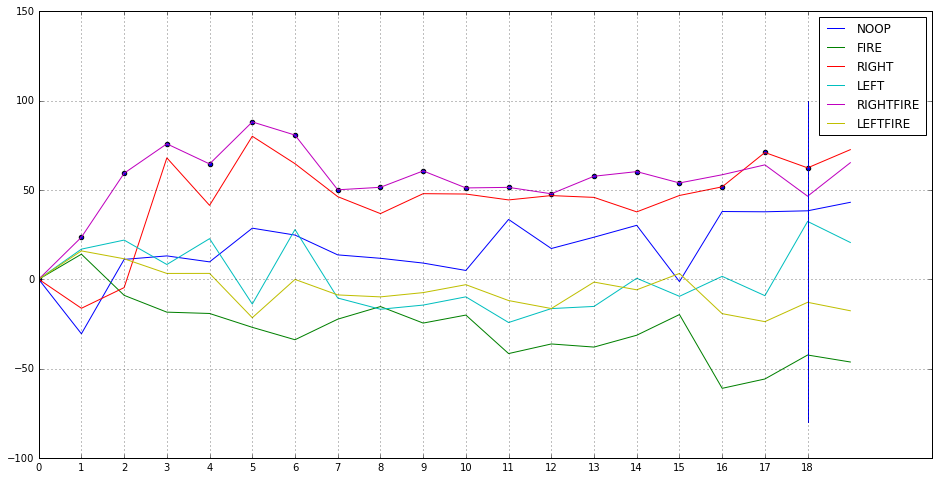

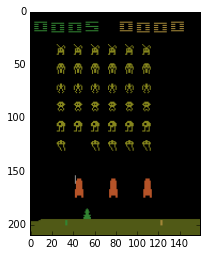

session # 0
 RIGHT(qv = 0.0) -> 0.0 |  RIGHT(qv = -15.9556274414) -> 0.0 |  RIGHTFIRE(qv = 43.412612915) -> 0.0 |  RIGHTFIRE(qv = 61.3540267944) -> 0.0 |  RIGHTFIRE(qv = 66.8139343262) -> 0.0 |  RIGHTFIRE(qv = 74.4738082886) -> 0.0 |  RIGHTFIRE(qv = 62.1702232361) -> 0.0 |  RIGHTFIRE(qv = 79.6487503052) -> 0.0 |  RIGHTFIRE(qv = 77.9586715698) -> 0.0 |  RIGHTFIRE(qv = 39.913066864) -> 0.0 |  RIGHTFIRE(qv = 45.2287139893) -> 0.0 |  RIGHTFIRE(qv = 47.2235336304) -> 0.0 |  RIGHTFIRE(qv = 46.5515556335) -> 0.0 |  RIGHTFIRE(qv = 46.5966873169) -> 0.0 |  RIGHTFIRE(qv = 30.5317802429) -> 0.0 |  RIGHTFIRE(qv = 42.2597312927) -> 0.0 |  RIGHTFIRE(qv = 58.8786354065) -> 0.0 |  RIGHTFIRE(qv = 53.2160110474) -> 0.0 |  RIGHTFIRE(qv = 68.9538421631) -> 0.0 |  RIGHT(qv = 58.37292099) -> 0.0 | reached max session length


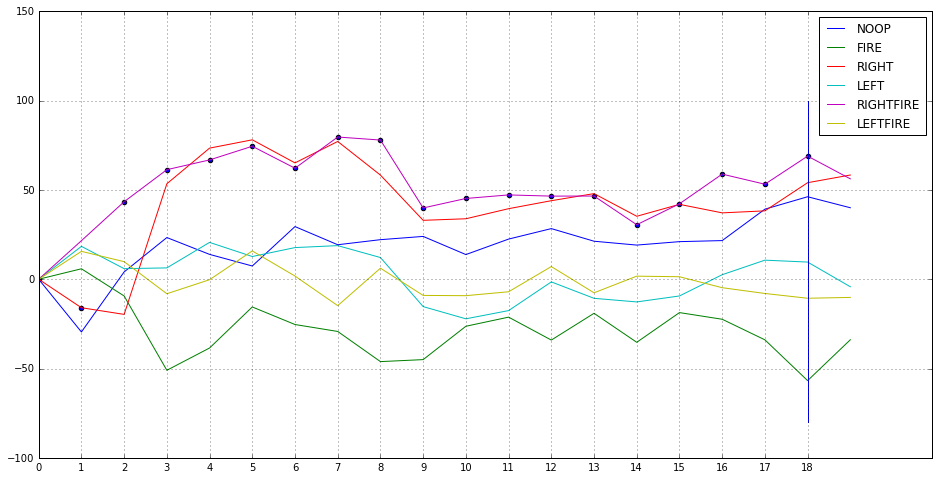

In [28]:
#visualize untrained network performance (which is mostly random)
epsilon.set_value(0.05)
display_sessions(with_plots=True)

# Training loop

In [29]:
#tools for model persistence (in progress now. Requires unique names)
from agentnet.utils.persistence import save,load
import os

In [30]:
from agentnet.display import Metrics
score_log = Metrics()

In [ ]:
#starting epoch
epoch_counter = 1
#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 50,loss 224698.10719, epsilon 0.45718, rewards: ( e-greedy 0.50000, greedy 0.05000) 
rec 224697.969 reg 0.138
epoch 100,loss 100456.06031, epsilon 0.41843, rewards: ( e-greedy 0.70000, greedy 0.34500) 
rec 100455.922 reg 0.138
epoch 150,loss 49553.45872, epsilon 0.38337, rewards: ( e-greedy 0.93000, greedy 0.41050) 
rec 49553.320 reg 0.138
epoch 200,loss 27589.28682, epsilon 0.35164, rewards: ( e-greedy 1.03700, greedy 0.96945) 
rec 27589.148 reg 0.138
epoch 250,loss 14434.78875, epsilon 0.32294, rewards: ( e-greedy 1.68330, greedy 1.12251) 
rec 14434.650 reg 0.138
epoch 300,loss 9098.02409, epsilon 0.29697, rewards: ( e-greedy 1.66497, greedy 1.21025) 
rec 9097.886 reg 0.138
epoch 350,loss 5056.12222, epsilon 0.27346, rewards: ( e-greedy 2.29847, greedy 1.28923) 
rec 5055.984 reg 0.138
epoch 400,loss 2781.57460, epsilon 0.25220, rewards: ( e-greedy 2.21863, greedy 1.41031) 
rec 2781.436 reg 0.138
epoch 450,loss 1078.88282, epsilon 0.23296, rewards: ( e-greedy 2.19676, greedy 2.1

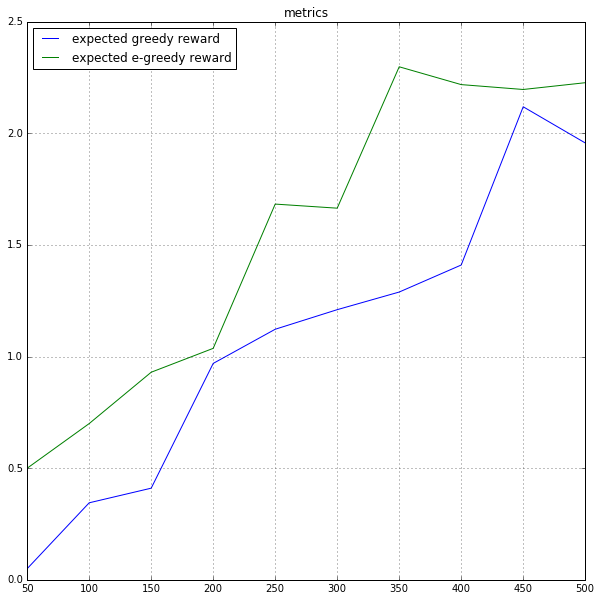

Random session examples


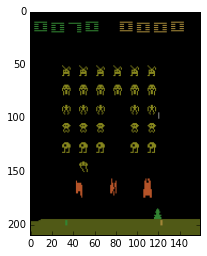

session # 0
 NOOP(qv = 0.0350546874106) -> 0.0 |  NOOP(qv = 82.0579299927) -> 0.0 |  NOOP(qv = 88.5662536621) -> 0.0 |  NOOP(qv = 89.5195388794) -> 0.0 |  LEFTFIRE(qv = 78.7137069702) -> 0.0 |  NOOP(qv = 90.0137939453) -> 0.0 |  NOOP(qv = 96.7565155029) -> 0.0 |  NOOP(qv = 92.1180496216) -> 0.0 |  NOOP(qv = 96.9585571289) -> 0.0 |  LEFTFIRE(qv = 81.4349822998) -> 0.0 |  NOOP(qv = 105.327980042) -> 0.0 |  LEFT(qv = 65.9888534546) -> 0.0 |  NOOP(qv = 89.7819976807) -> 0.0 |  NOOP(qv = 99.8884124756) -> 0.0 |  NOOP(qv = 94.5009918213) -> 0.0 |  NOOP(qv = 100.432395935) -> 0.0 |  FIRE(qv = 70.8429946899) -> 0.0 |  NOOP(qv = 98.9279937744) -> 0.0 |  NOOP(qv = 88.2660446167) -> 0.0 |  NOOP(qv = 80.1562194824) -> 0.0 | reached max session length


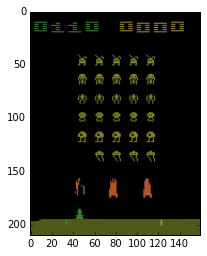

session # 0
 FIRE(qv = 0.076267555356) -> 0.0 |  LEFT(qv = 76.2811355591) -> 0.0 |  NOOP(qv = 89.4719314575) -> 0.0 |  NOOP(qv = 59.3079223633) -> 0.0 |  LEFT(qv = 87.1231231689) -> 0.0 |  LEFT(qv = 99.47631073) -> 0.0 |  LEFT(qv = 85.7694015503) -> 0.0 |  NOOP(qv = 80.7145080566) -> 0.0 |  LEFT(qv = 73.0419998169) -> 0.0 |  RIGHTFIRE(qv = 71.7589187622) -> 10.0 |  NOOP(qv = 86.3348312378) -> 0.0 |  RIGHTFIRE(qv = 88.8739395142) -> 0.0 |  NOOP(qv = 94.6012191772) -> 0.0 |  NOOP(qv = 88.142616272) -> 0.0 |  NOOP(qv = 89.1455154419) -> 0.0 |  FIRE(qv = 70.2293624878) -> 0.0 |  NOOP(qv = 87.720664978) -> 0.0 |  NOOP(qv = 84.2307815552) -> 0.0 |  NOOP(qv = 88.4449920654) -> 0.0 |  LEFT(qv = 68.0985794067) -> 0.0 | reached max session length


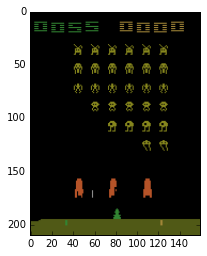

session # 0
 RIGHTFIRE(qv = 0.0926568731666) -> 0.0 |  RIGHTFIRE(qv = 90.1418762207) -> 0.0 |  RIGHTFIRE(qv = 100.012901306) -> 0.0 |  RIGHTFIRE(qv = 69.1215438843) -> 0.0 |  NOOP(qv = 93.2106552124) -> 0.0 |  NOOP(qv = 83.8724365234) -> 0.0 |  NOOP(qv = 77.1771621704) -> 0.0 |  NOOP(qv = 84.6178894043) -> 0.0 |  NOOP(qv = 88.0369110107) -> 0.0 |  NOOP(qv = 53.5087623596) -> 0.0 |  FIRE(qv = 81.1764526367) -> 0.0 |  NOOP(qv = 98.8904342651) -> 0.0 |  NOOP(qv = 81.5339736938) -> 0.0 |  FIRE(qv = 91.1603927612) -> 0.0 |  FIRE(qv = 90.7267227173) -> 0.0 |  NOOP(qv = 85.3656921387) -> 0.0 |  FIRE(qv = 91.0459976196) -> 0.0 |  NOOP(qv = 70.8424224854) -> 0.0 |  NOOP(qv = 91.4208526611) -> 0.0 |  NOOP(qv = 81.8124847412) -> 0.0 | reached max session length
epoch 550,loss 546.19620, epsilon 0.19979, rewards: ( e-greedy 2.15438, greedy 2.26161) 
rec 546.058 reg 0.138
epoch 600,loss 271.04058, epsilon 0.18554, rewards: ( e-greedy 2.03894, greedy 2.03545) 
rec 270.902 reg 0.138
epoch 650,loss 32

In [ ]:
n_epochs = 5000
batch_size= 10

for i in range(n_epochs):    
    
    
    #train
    update_pool(env,pool,replay_seq_len)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        update_pool(env,pool,replay_seq_len)

        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))
        update_pool(env,pool,replay_seq_len)

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

    if epoch_counter %500 ==0:
        print "Learning curves:"
        score_log.plot()


        print "Random session examples"
        display_sessions(with_plots=False)
    
    #save snapshot
    if epoch_counter %1000 ==0:
        snap_name = "{}.epoch{}.pcl".format(os.path.join(snapshot_path,experiment_setup_name), epoch_counter)
        save(resolver,snap_name)
        print "saved", snap_name

        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results

In [ ]:
score_log.plot("final")

In [ ]:
print "Random session examples"
display_sessions(with_plots=True)


# Submission

In [ ]:
epsilon.set_value(0)

In [ ]:

save_path = '/tmp/AgentNet-simplenet-SpaceInvadersv0-Recording0'

subm_env = gym.make(GAME_TITLE)

#starting monitor. This setup does not write videos
subm_env.monitor.start(save_path,lambda i: False,force=True)

#this setup does
#subm_env.monitor.start(save_path,force=True)


for i_episode in xrange(100):
    
    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = [np.zeros((1,)+tuple(mem.output_shape[1:]),dtype=floatX) 
                         for mem in agent.state_variables]
    
    
    t = 0
    while True:

        action,new_memories = step([observation],prev_memories)
        observation, reward, done, info = subm_env.step(action)
        
        prev_memories = new_memories
        if done:
            print "Episode finished after {} timesteps".format(t+1)
            break
        t+=1

subm_env.monitor.close()

In [ ]:
gym.monitoring._monitors.clear()

In [ ]:

gym.upload(save_path,
           
           #this notebook
           writeup=<url to my gist>, 
           
           #your api key
           api_key=<my_own_api_key>)
